In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import time
from pylab import *
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
train_source = os.path.abspath(os.path.join('../../data/train_source/'))
test_source = os.path.abspath(os.path.join('../../data/test_source/'))
train_path = os.path.abspath(os.path.join('../../data/train/'))
test_path = os.path.abspath(os.path.join('../../data/test/'))
dest_path_bsu = os.path.abspath(os.path.join('../../data/final_bsu/'))
dest_path_bs = os.path.abspath(os.path.join('../../data/final_bs/'))
val_path_bs = os.path.abspath(os.path.join('../../data/validation_bs/'))
val_path_bsu = os.path.abspath(os.path.join('../../data/validation_bsu/'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
#print(device_lib.list_local_devices())

In [2]:
# 1. Train 10 without weights 128 bs - DONE
# 2. Train 10 without weights 256 bs - DONE
# 3. Train 10 without weights 1024 bs - DONE
# 4. Train 10 weights 128 bs - DONE
# 5. Train 10 weights 256 bs - DONE
# 6. Train 10 weights 1024 bs - DONE
# 7. Train 10 without weights 128 bsu - DONE
# 8. Train 10 without weights 256 bsu - DONE
# 9. Train 10 without weights 1024 bsu - DONE
# 10. Train 10 weights 128 bsu - RUNNING
# 11. Train 10 weights 256 bsu
# 12. Train 10 weights 1024 bsu


# 13. Train 50 without weights 128 bs
# 14. Train 50 without weights 256 bs
# 15. Train 50 without weights 1024 bs
# 16. Train 50 weights 128 bs
# 17. Train 50 weights 256 bs
# 18. Train 50 weights 1024 bs
# 19. Train 50 without weights 128 bsu
# 20. Train 50 without weights 256 bsu
# 21. Train 50 without weights 1024 bsu
# 22. Train 50 weights 128 bsu
# 23. Train 50 weights 256 bsu
# 24. Train 50 weights 1024 bsu


In [3]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
h = 30
w = 2
d = 2

In [4]:
num_frames = 10
# FOR BS Training 
# Train
X_train = np.load(dest_path_bs + '/' + str(num_frames) + '_X_train.npy')
Y_train = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_train.npy')
F_train = np.load(dest_path_bs + '/' + str(num_frames) + '_F_train.npy')
X_test = np.load(dest_path_bs + '/' + str(num_frames) + '_X_test.npy')
Y_test = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_test.npy')
F_test = np.load(dest_path_bs + '/' + str(num_frames) + '_F_test.npy')

print(X_train.shape)
print(X_test.shape)

#X_train = np.append(X_train, X_test, axis=0)
#Y_train = np.append(Y_train, Y_test, axis=0)
#F_train = np.append(F_train, F_test, axis=0)
#print(X_train.shape)

# Validation
X_val = np.load(val_path_bs + '/' + str(num_frames) + '_X_val.npy')
Y_val = np.load(val_path_bs + '/' + str(num_frames) + '_Y_val.npy')
print(X_val.shape)

(265825, 10, 30, 2, 2)
(93741, 10, 30, 2, 2)
(19733, 10, 30, 2, 2)


In [5]:
# FOR BSU Training 
# Train
Xu_train = np.load(dest_path_bsu + '/' + str(num_frames) + '_X_train.npy')
Yu_train = np.load(dest_path_bsu + '/' + str(num_frames) + '_Y_train.npy')
Fu_train = np.load(dest_path_bsu + '/' + str(num_frames) + '_F_train.npy')
Xu_test = np.load(dest_path_bsu + '/' + str(num_frames) + '_X_test.npy')
Yu_test = np.load(dest_path_bsu + '/' + str(num_frames) + '_Y_test.npy')
Fu_test = np.load(dest_path_bsu + '/' + str(num_frames) + '_F_test.npy')

print(Xu_train.shape)
print(Xu_test.shape)

Xu_train = np.append(Xu_train, Xu_test, axis=0)
Yu_train = np.append(Yu_train, Yu_test, axis=0)
Fu_train = np.append(Fu_train, Fu_test, axis=0)
print(Xu_train.shape)

# Validation
Xu_val = np.load(val_path_bsu + '/' + str(num_frames) + '_X_val.npy')
Yu_val = np.load(val_path_bsu + '/' + str(num_frames) + '_Y_val.npy')

(50000, 10, 30, 2, 2)
(50000, 10, 30, 2, 2)
(100000, 10, 30, 2, 2)


In [33]:
# COMBINE BS AND BSU
X_train = np.append(X_train, Xu_train, axis=0)
Y_train = np.append(Y_train, Yu_train, axis=0)
F_train = np.append(F_train, Fu_train, axis=0)
print(X_train.shape)
print(F_train.shape)

X_val = np.append(X_val, Xu_val, axis=0)
Y_val = np.append(Y_val, Yu_val, axis=0)
print(X_val.shape)

(465825, 10, 30, 2, 2)
(465825,)
(375733, 10, 30, 2, 2)


### Model Initialisation

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

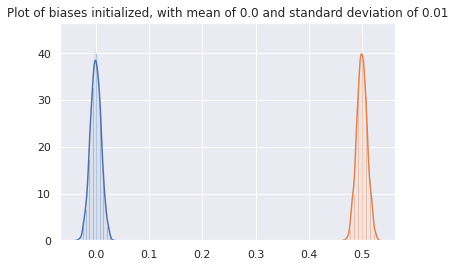

In [7]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [8]:
class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))
        self.cat_true_positives.assign_add(true_poss)

    def result(self):
        return self.cat_true_positives

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 30, 2, 2)]    0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 10, 120)           0         
_________________________________________________________________
tcn_3 (TCN)                  (None, 128)               473984    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
Total params: 490,496
Trainable params: 490,496
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output 

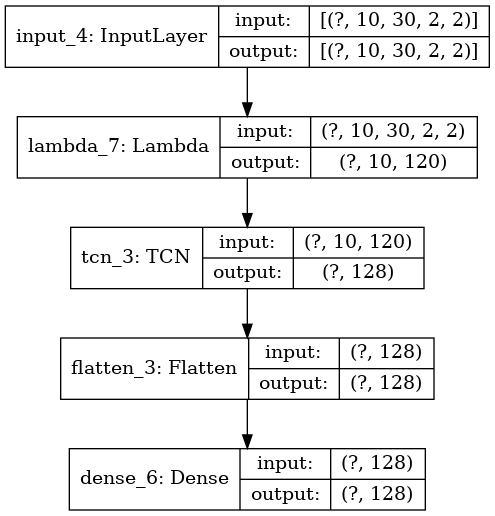

In [30]:
def embedding_model(frames, h, w, c, input_shape, dimensions, include_top=False, pooling=None, classes=1):  
    inp = Input(shape=(frames, h, w, c))
    out = Lambda(lambda y: K.reshape(y, (-1, h, w, c)))(inp)
    num_features_cnn = np.prod(K.int_shape(out)[1:])
    out = Lambda(lambda y: K.reshape(y, (-1, num_frames, num_features_cnn)))(inp)
    out = TCN(nb_filters=128, kernel_size=2, return_sequences=False, dilations=[1, 2, 4, 8, 16, 32, 64], 
              activation=tf.keras.activations.swish, nb_stacks=1, dropout_rate=0.08)(out)
    out = Flatten()(out)
    out = Dense(128, activation=None, kernel_regularizer=l2(1e-3), kernel_initializer='he_uniform')(out)    
    return Model(inputs=inp, outputs=out)

def triplets_model(input_shape, embedding, include_top=False, pooling=None):
    anchor_input = Input(shape=input_shape, name='anchor_input')
    encoded_a = embedding(anchor_input)
    prediction = Dense(nb_classes+1, activation='softmax',bias_initializer=initialize_bias)(encoded_a)
    triplet_net = Model(inputs=[anchor_input],outputs=[prediction])
    return triplet_net

build_embedding = embedding_model(num_frames, h, w, d, input_shape=(num_frames, h, w, d), dimensions=60)
build_triplet = triplets_model(input_shape=(num_frames, h, w, d), embedding=build_embedding)
optimizer = Adam(lr = 0.00006)
build_triplet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=optimizer, 
                      metrics=[metrics.MeanSquaredError(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),
                      tf.keras.metrics.CategoricalAccuracy(name='acc'),
                      CategoricalTruePositives(nb_classes, batch_size)])
build_embedding.summary()
build_triplet.summary()
tcn_full_summary(build_embedding, expand_residual_blocks=True)
plot_model(build_embedding, 'multi_input_and_output_model.png', show_shapes=True)

### Training - 10 Frames 

In [32]:
labels_train = K.one_hot(Y_train, nb_classes+1)
labels_val = K.one_hot(Y_val, nb_classes+1)
history = build_triplet.fit(x=X_train, y=labels_train, batch_size=batch_size, epochs=200, verbose=1, callbacks=None, 
                              validation_split=0.02, validation_data=None, shuffle=True, class_weight=None, 
                              sample_weight=F_train, initial_epoch=0, steps_per_epoch=50, validation_steps=None)

Epoch 1/200


InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_7/dense_7/Softmax:0) = ] [[nan nan nan]...] [y (Cast_5/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/Assert}}]] [Op:__inference_train_function_2718620]

Function call stack:
train_function


In [ ]:
result = build_triplet.predict(X_val)
preds_raw = np.argmax(result, axis=1)
preds = K.one_hot(preds_raw, nb_classes+1)
    
r = tf.keras.metrics.Recall()
r.update_state(labels_val, preds)
r.result().numpy()
print('Recall ' + str(r.result()))

p = tf.keras.metrics.Precision()
p.update_state(labels_val, preds)
p.result().numpy()
print('Precision ' + str(p.result()))

f1 = 2*((p.result()*r.result())/(p.result()+r.result()+K.epsilon()))
print('F1 ' + str(f1))

import statistics
acc = statistics.mean(history.history['val_acc']) 
print('accuracy ' + str(acc))

### Plotting

In [ ]:
import pickle

with open(os.path.abspath(os.path.join('../../results/10/')), 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

In [ ]:
history_retrieve = pickle.load(open(os.path.abspath(os.path.join('../../results/10/')), "rb"))

In [ ]:
# summarize history for accuracy
plt.plot(history_retrieve['acc'])
plt.plot(history_retrieve['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_retrieve['loss'])
plt.plot(history_retrieve['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()